
==== Training ChainActivation to mimic target: sigmoid ====
[step     1/1200] loss = 1.383308e+01
[step   200/1200] loss = 6.098207e-01
[step   400/1200] loss = 1.553137e-01
[step   600/1200] loss = 4.473530e-02
[step   800/1200] loss = 2.665922e-02
[step  1000/1200] loss = 2.558336e-02
[step  1200/1200] loss = 2.423434e-02
Finished sigmoid; final loss 2.423434e-02

==== Training ChainActivation to mimic target: relu ====
[step     1/1200] loss = 6.930579e+01
[step   200/1200] loss = 1.180194e-01
[step   400/1200] loss = 1.305677e-01
[step   600/1200] loss = 1.312395e-01
[step   800/1200] loss = 1.260020e-01
[step  1000/1200] loss = 1.252913e-01
[step  1200/1200] loss = 1.390268e-01
Finished relu; final loss 1.390268e-01

==== Training ChainActivation to mimic target: mish ====
[step     1/1200] loss = 6.931410e+01
[step   200/1200] loss = 1.480705e-01
[step   400/1200] loss = 1.614491e-01
[step   600/1200] loss = 1.634236e-01
[step   800/1200] loss = 1.572583e-01
[step  1000/1200] lo

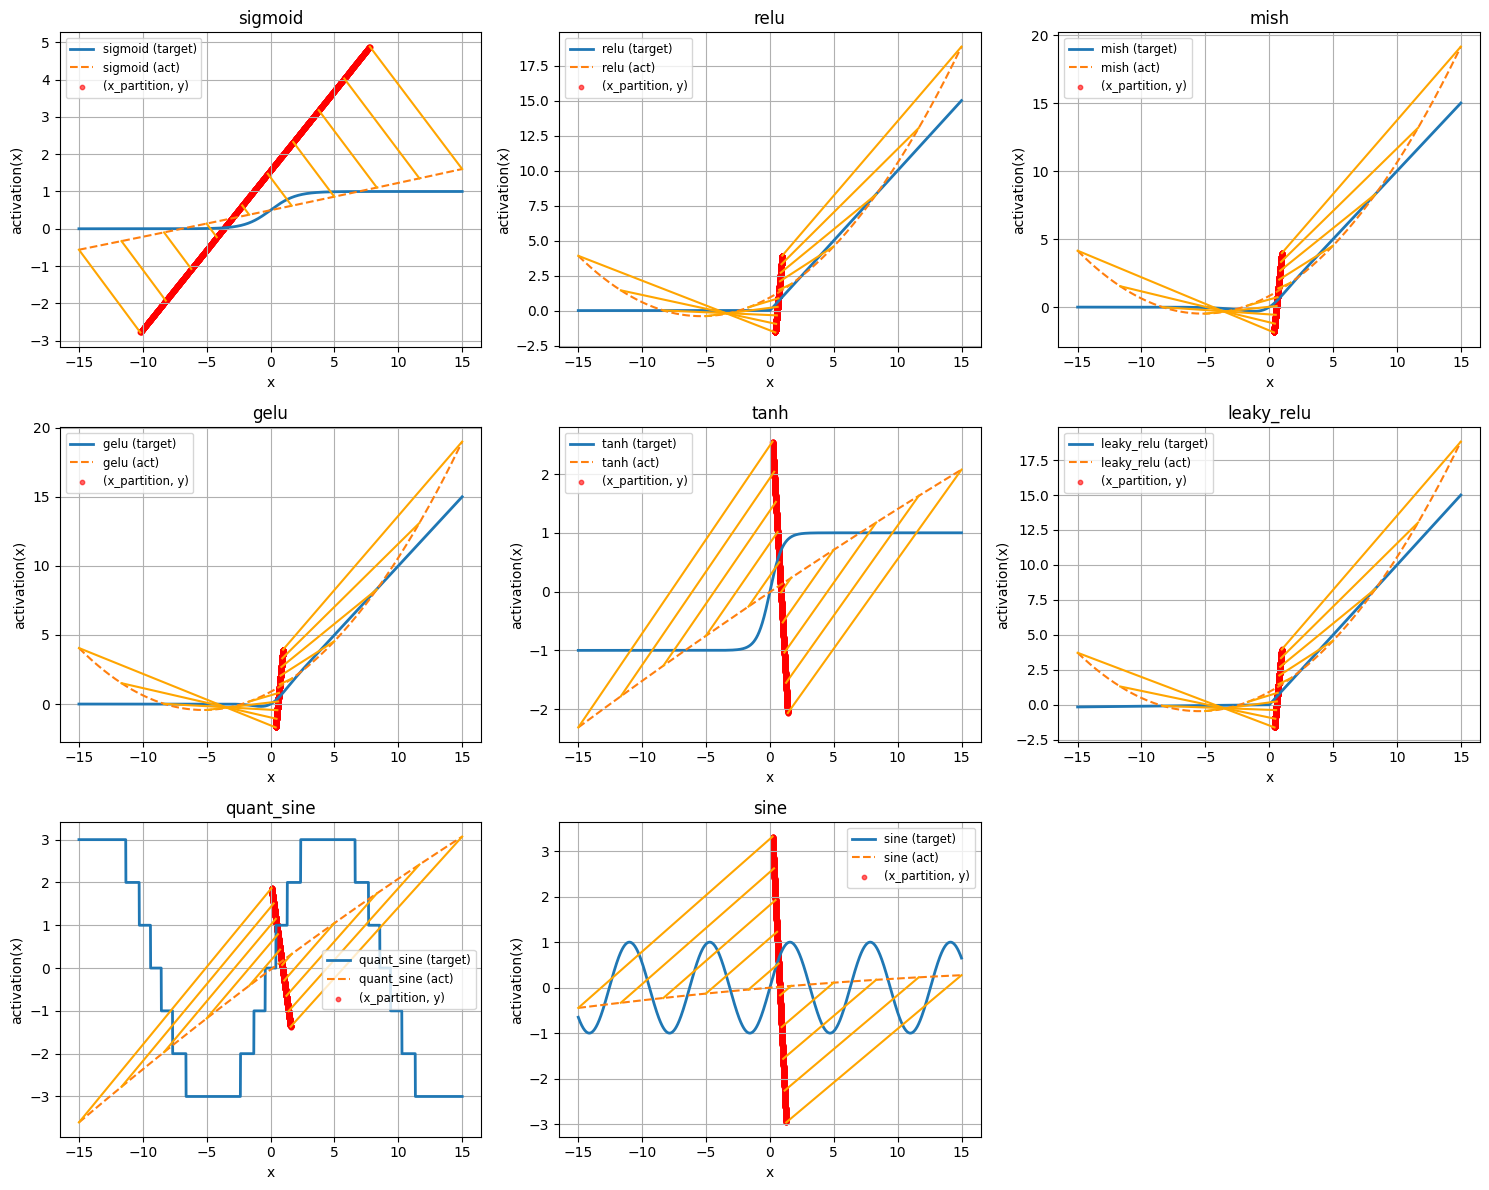

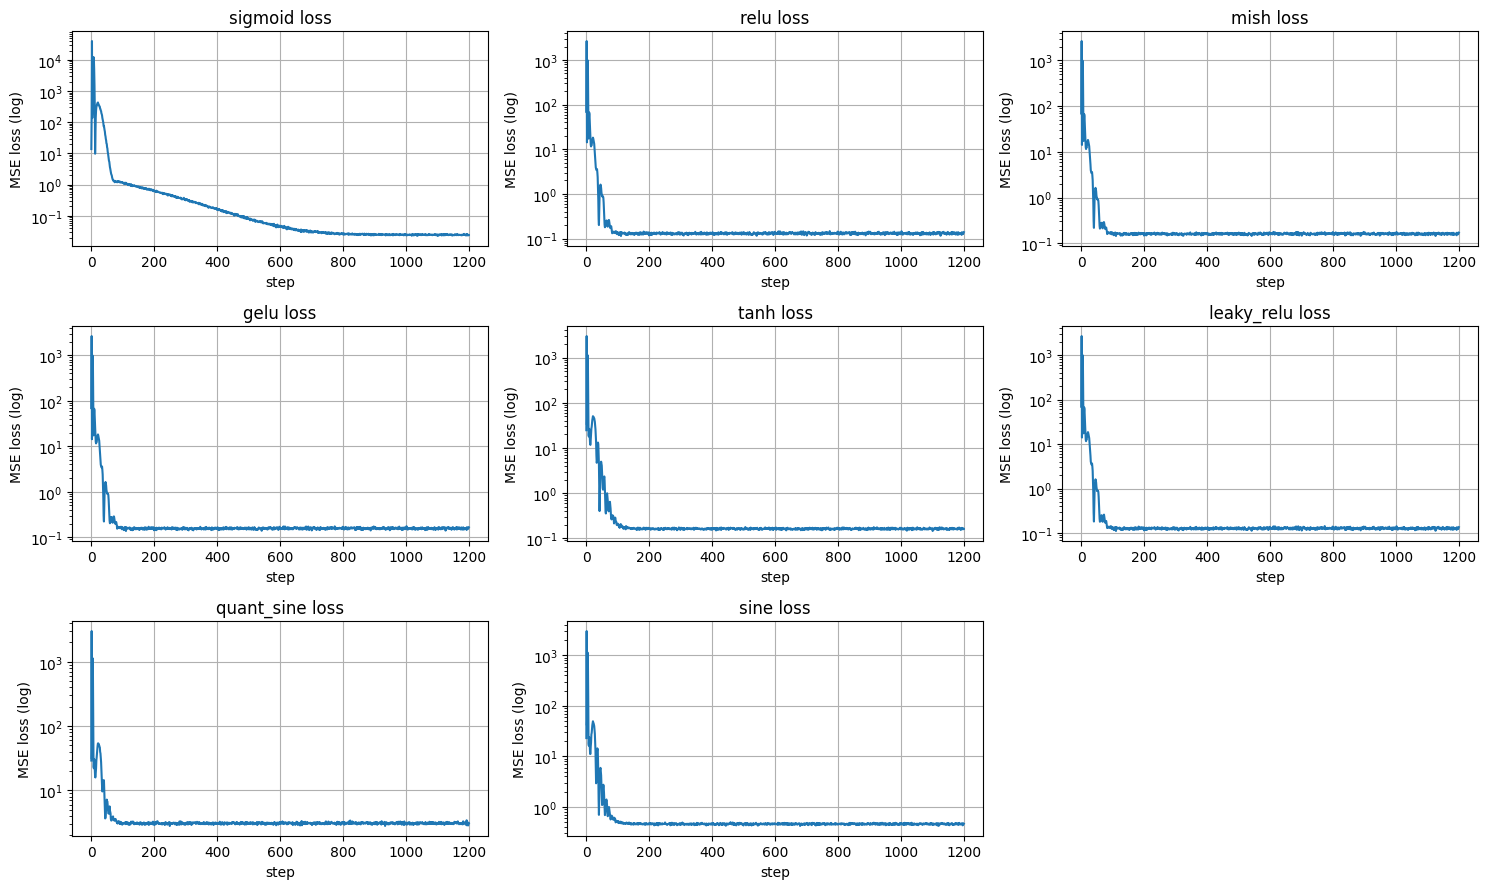

In [3]:
import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from math import ceil

# ----------------------
# Dynamic Piecewise Linear Activation
# ----------------------
class DynamicPiecewiseLinearActivation(nn.Module):
    def __init__(self):
        super().__init__()        
        self.l1 = nn.Linear(1, 128)
        self.act1 = nn.Tanh()
        self.y_gen = nn.Linear(128, 1)
        self.m_gen = nn.Linear(128, 1)
        self.x_gen = nn.Linear(128, 1)
        self.gen = nn.Linear(3, 3)

    def forward(self, x_input, return_params=False):
        original_shape = x_input.shape
        x_flat = x_input.view(-1, 1)

        o1_out = self.l1(x_flat)
        #o1_out = self.act1(o1_out)
        y = self.y_gen(o1_out)
        m = self.m_gen(o1_out)
        x_partitions = self.x_gen(o1_out)

        combined_ymx = torch.cat([y, m, x_partitions], dim=1)
        out = self.gen(combined_ymx)

        y, m, x_partitions = torch.split(out, [1, 1, 1], dim=1)
        y_out = y + m * (x_flat - x_partitions)

        if return_params:
            # return y_out + the (y, x_partition) points
            return y_out.view(original_shape), y.view(-1), x_partitions.view(-1), m.view(-1)
        return y_out.view(original_shape)

# -----------------------
# target activation functions (torch)
# -----------------------
def sigmoid_t(x): return torch.sigmoid(x)
def relu_t(x): return torch.nn.functional.relu(x)
def mish_t(x): return x * torch.tanh(torch.nn.functional.softplus(x))
def gelu_t(x): return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))
def tanh_t(x): return torch.tanh(x)
def leaky_relu_t(x, alpha=0.01): return torch.where(x >= 0, x, alpha * x)
def quantized_sine_torch(x, A=3.4, k=0.35): return torch.round(A * torch.sin(k * x))
def sin_t(x): return torch.sin(x)

# -----------------------
# training function
# -----------------------
def train_act_to_target(act: DynamicPiecewiseLinearActivation, target_fn, x_min=-10.0, x_max=10.0,
                          steps=1000, batch_size=1024, lr=1e-2, device='cpu',
                          print_every=200, seed=0):
    torch.manual_seed(seed)
    act.to(device)
    optimizer = torch.optim.Adam(act.parameters(), lr=lr)
    loss_hist = []

    for step in range(steps):
        x_batch = (x_max - x_min) * torch.rand(batch_size, device=device) + x_min
        y_pred = act(x_batch)
        y_true = target_fn(x_batch)
        if y_true.ndim > 1:
            y_true = y_true.view(-1)
        loss = torch.mean((y_pred - y_true) ** 2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_hist.append(loss.item())

        if (step + 1) % print_every == 0 or step == 0 or step == steps - 1:
            print(f"[step {step+1:5d}/{steps}] loss = {loss.item():.6e}")

    return loss_hist


# -----------------------
# main experiment
# -----------------------
if __name__ == "__main__":
    torch.manual_seed(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    x_min, x_max = -10.0, 10.0
    x_plot = torch.linspace(x_min - 5.0, x_max + 5.0, 2000, device=device)

    targets = {
        'sigmoid': sigmoid_t,
        'relu': relu_t,
        'mish': mish_t,
        'gelu': gelu_t,
        'tanh': tanh_t,
        'leaky_relu': lambda x: leaky_relu_t(x, alpha=0.01),
        'quant_sine': lambda x: quantized_sine_torch(x, A=3.4, k=0.35),
        'sine': sin_t
    }

    steps = 1200
    batch_size = 1024
    lr = 0.03

    results = {}
    for name, fn in targets.items():
        print(f"\n==== Training ChainActivation to mimic target: {name} ====")
        act = DynamicPiecewiseLinearActivation().to(device)

        losses = train_act_to_target(act, fn,
                                     x_min=x_min, x_max=x_max,
                                     steps=steps, batch_size=batch_size, lr=lr,
                                     device=device, print_every=200, seed=42)

        with torch.no_grad():
            y_target = fn(x_plot).cpu().numpy()
            y_act, y_pts, x_pts, m = act(x_plot, return_params=True)
            y_act = y_act.cpu().numpy()
            y_pts, x_pts, m = y_pts.cpu().numpy(), x_pts.cpu().numpy(), m.cpu().numpy()

        results[name] = {
            'act': act,
            'x': x_plot.cpu().numpy(),
            'y_target': y_target,
            'y_act': y_act,
            'losses': losses,
            'y_pts': y_pts,
            'x_pts': x_pts,
            'm': m
        }
        print(f"Finished {name}; final loss {losses[-1]:.6e}")

    # plotting curves + generated points (y, x_partition)
    names = list(results.keys())
    n = len(names)
    ncols = 3
    nrows = ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), squeeze=False)
    axes = axes.flatten()

    for i, name in enumerate(names):
        r = results[name]
        ax = axes[i]
        ax.plot(r['x'], r['y_target'], label=f"{name} (target)", linewidth=2.0)
        ax.plot(r['x'], r['y_act'], linestyle='--', label=f"{name} (act)", linewidth=1.5)

        # scatter only (x_partition, y) points
        ax.scatter(r['x_pts'], r['y_pts'], c='red', s=10, alpha=0.6, label="(x_partition, y)")

        gen_x0, gen_y0 = r['x_pts'], r['y_pts']
        data_x1, pred_y1 = r['x'], r['y_act']
        # Number of points to select
        k = 10  
        indices = np.linspace(0, len(gen_x0)-1, k, dtype=int)
        # Prepare x and y pairs for all segments
        gen_data_X = np.column_stack([gen_x0[indices], data_x1[indices]]).T   # shape (2, k)
        gen_pred_Y = np.column_stack([gen_y0[indices], pred_y1[indices]]).T   # shape (2, k)
        # Plot all segments at once
        ax.plot(gen_data_X, gen_pred_Y, color="orange")
        
        ax.set_title(name)
        ax.set_xlabel('x')
        ax.set_ylabel('activation(x)')
        ax.grid(True)
        ax.legend(fontsize='small')

    for j in range(n, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

    # loss curves
    fig2, axes2 = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False)
    axes2 = axes2.flatten()
    for i, name in enumerate(names):
        ax = axes2[i]
        ax.plot(results[name]['losses'])
        ax.set_title(f"{name} loss")
        ax.set_yscale('log')
        ax.set_xlabel('step')
        ax.set_ylabel('MSE loss (log)')
        ax.grid(True)
    for j in range(n, len(axes2)):
        fig2.delaxes(axes2[j])
    plt.tight_layout()
    plt.show()



==== Training ChainActivation to mimic target: sigmoid ====
[step     1/1200] loss = 1.379777e+01
[step   200/1200] loss = 4.843713e-05
[step   400/1200] loss = 6.213152e-06
[step   600/1200] loss = 3.327475e-06
[step   800/1200] loss = 2.502209e-06
[step  1000/1200] loss = 1.755284e-06
[step  1200/1200] loss = 1.319517e-06
Finished sigmoid; final loss 1.319517e-06

==== Training ChainActivation to mimic target: relu ====
[step     1/1200] loss = 2.291705e+01
[step   200/1200] loss = 4.116193e-04
[step   400/1200] loss = 1.713581e-04
[step   600/1200] loss = 1.187964e-04
[step   800/1200] loss = 5.434676e-05
[step  1000/1200] loss = 4.627882e-05
[step  1200/1200] loss = 5.590104e-05
Finished relu; final loss 5.590104e-05

==== Training ChainActivation to mimic target: mish ====
[step     1/1200] loss = 2.294133e+01
[step   200/1200] loss = 4.053507e-05
[step   400/1200] loss = 1.102995e-05
[step   600/1200] loss = 4.793848e-06
[step   800/1200] loss = 2.212514e-06
[step  1000/1200] lo

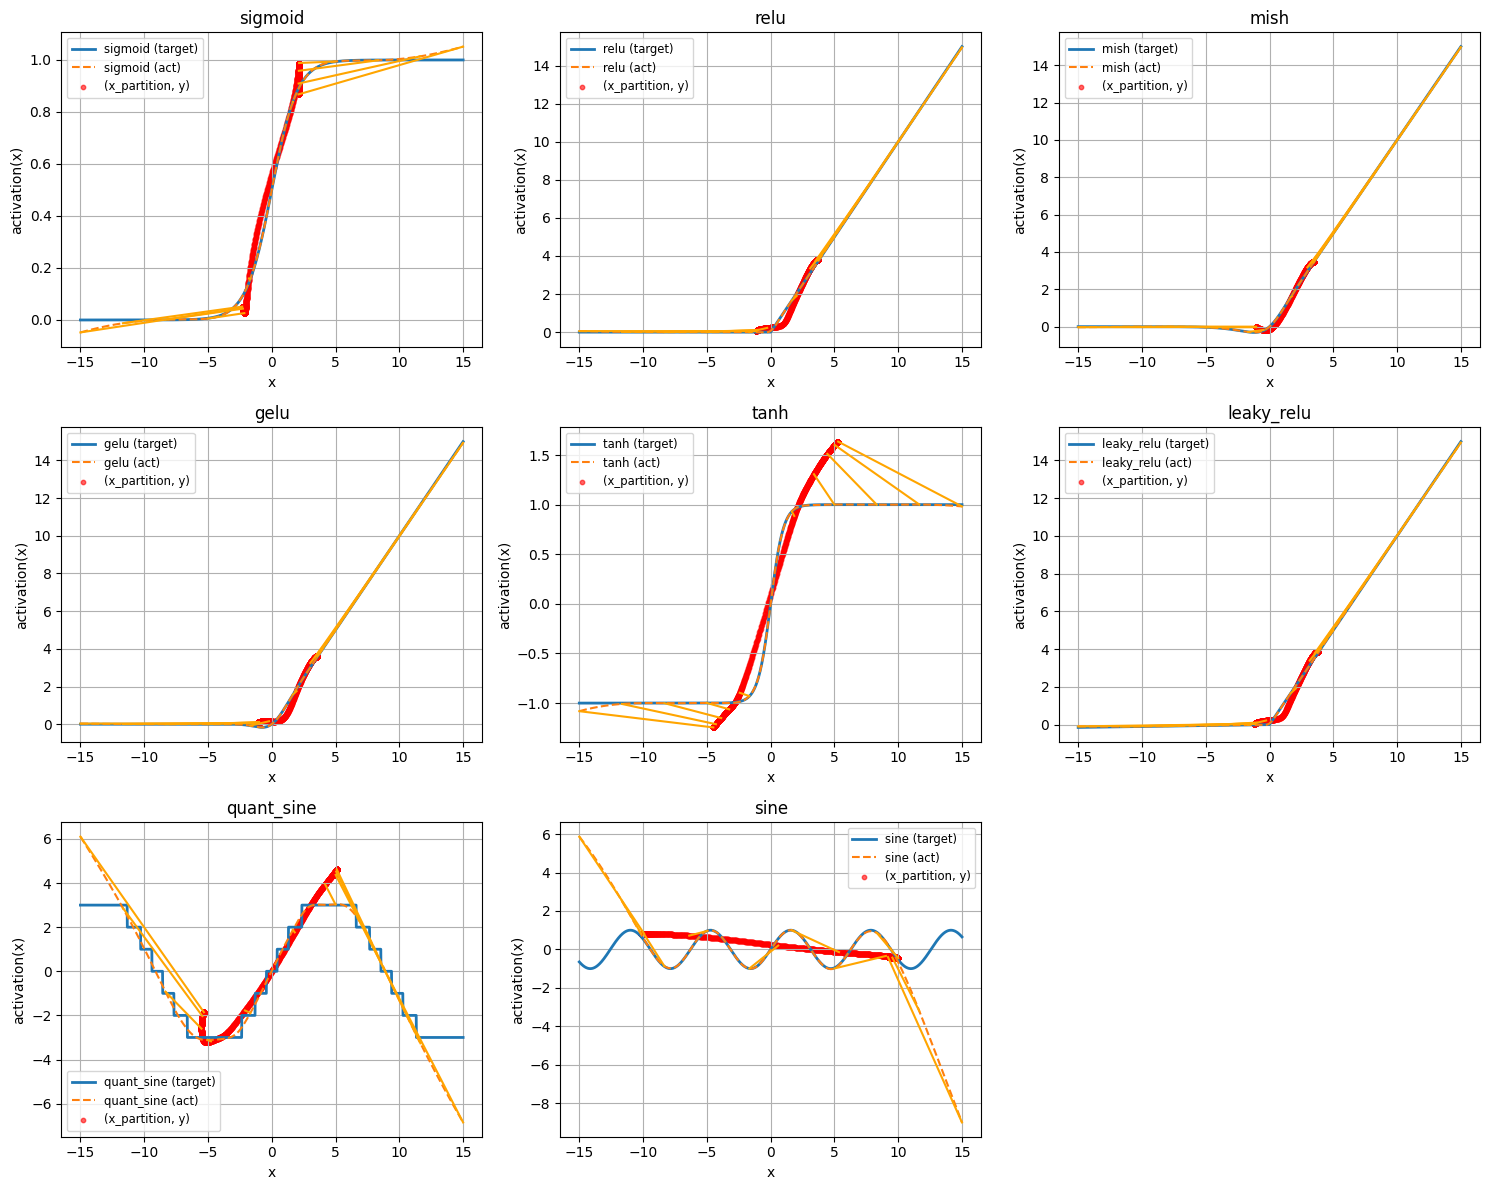

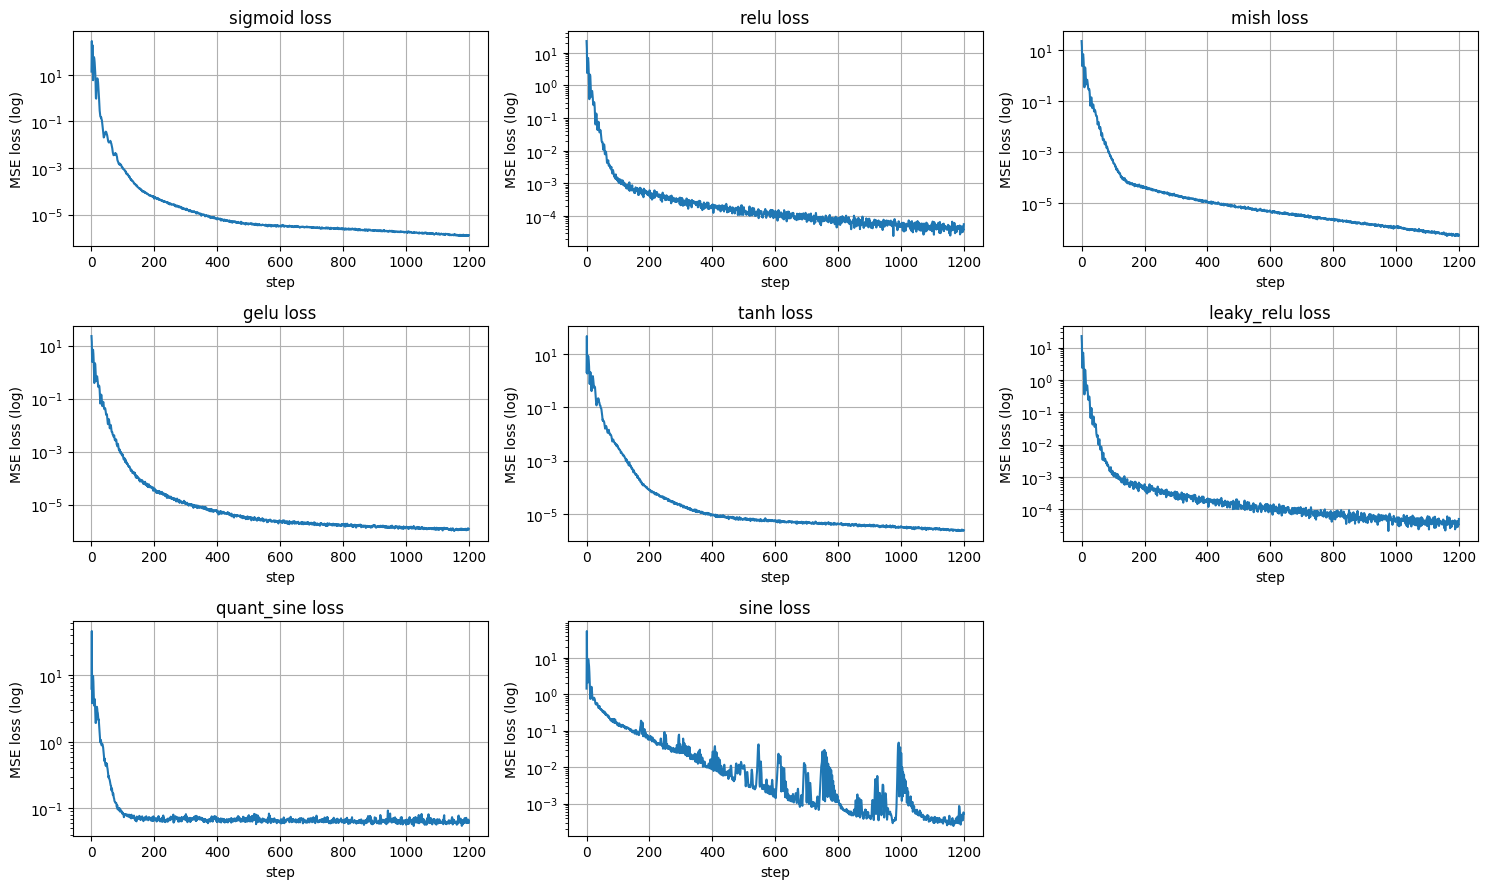

In [2]:
import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from math import ceil

# ----------------------
# Dynamic Piecewise Linear Activation
# ----------------------
class DynamicPiecewiseLinearActivation(nn.Module):
    def __init__(self):
        super().__init__()        
        self.l1 = nn.Linear(1, 128)
        self.act1 = nn.Tanh()
        self.y_gen = nn.Linear(128, 1)
        self.m_gen = nn.Linear(128, 1)
        self.x_gen = nn.Linear(128, 1)
        self.gen = nn.Linear(3, 3)

    def forward(self, x_input, return_params=False):
        original_shape = x_input.shape
        x_flat = x_input.view(-1, 1)

        o1_out = self.l1(x_flat)
        o1_out = self.act1(o1_out)
        y = self.y_gen(o1_out)
        m = self.m_gen(o1_out)
        x_partitions = self.x_gen(o1_out)

        combined_ymx = torch.cat([y, m, x_partitions], dim=1)
        out = self.gen(combined_ymx)

        y, m, x_partitions = torch.split(out, [1, 1, 1], dim=1)
        y_out = y + m * (x_flat - x_partitions)

        if return_params:
            # return y_out + the (y, x_partition) points
            return y_out.view(original_shape), y.view(-1), x_partitions.view(-1), m.view(-1)
        return y_out.view(original_shape)

# -----------------------
# target activation functions (torch)
# -----------------------
def sigmoid_t(x): return torch.sigmoid(x)
def relu_t(x): return torch.nn.functional.relu(x)
def mish_t(x): return x * torch.tanh(torch.nn.functional.softplus(x))
def gelu_t(x): return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))
def tanh_t(x): return torch.tanh(x)
def leaky_relu_t(x, alpha=0.01): return torch.where(x >= 0, x, alpha * x)
def quantized_sine_torch(x, A=3.4, k=0.35): return torch.round(A * torch.sin(k * x))
def sin_t(x): return torch.sin(x)

# -----------------------
# training function
# -----------------------
def train_act_to_target(act: DynamicPiecewiseLinearActivation, target_fn, x_min=-10.0, x_max=10.0,
                          steps=1000, batch_size=1024, lr=1e-2, device='cpu',
                          print_every=200, seed=0):
    torch.manual_seed(seed)
    act.to(device)
    optimizer = torch.optim.Adam(act.parameters(), lr=lr)
    loss_hist = []

    for step in range(steps):
        x_batch = (x_max - x_min) * torch.rand(batch_size, device=device) + x_min
        y_pred = act(x_batch)
        y_true = target_fn(x_batch)
        if y_true.ndim > 1:
            y_true = y_true.view(-1)
        loss = torch.mean((y_pred - y_true) ** 2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_hist.append(loss.item())

        if (step + 1) % print_every == 0 or step == 0 or step == steps - 1:
            print(f"[step {step+1:5d}/{steps}] loss = {loss.item():.6e}")

    return loss_hist


# -----------------------
# main experiment
# -----------------------
if __name__ == "__main__":
    torch.manual_seed(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    x_min, x_max = -10.0, 10.0
    x_plot = torch.linspace(x_min - 5.0, x_max + 5.0, 2000, device=device)

    targets = {
        'sigmoid': sigmoid_t,
        'relu': relu_t,
        'mish': mish_t,
        'gelu': gelu_t,
        'tanh': tanh_t,
        'leaky_relu': lambda x: leaky_relu_t(x, alpha=0.01),
        'quant_sine': lambda x: quantized_sine_torch(x, A=3.4, k=0.35),
        'sine': sin_t
    }

    steps = 1200
    batch_size = 1024
    lr = 0.03

    results = {}
    for name, fn in targets.items():
        print(f"\n==== Training ChainActivation to mimic target: {name} ====")
        act = DynamicPiecewiseLinearActivation().to(device)

        losses = train_act_to_target(act, fn,
                                     x_min=x_min, x_max=x_max,
                                     steps=steps, batch_size=batch_size, lr=lr,
                                     device=device, print_every=200, seed=42)

        with torch.no_grad():
            y_target = fn(x_plot).cpu().numpy()
            y_act, y_pts, x_pts, m = act(x_plot, return_params=True)
            y_act = y_act.cpu().numpy()
            y_pts, x_pts, m = y_pts.cpu().numpy(), x_pts.cpu().numpy(), m.cpu().numpy()

        results[name] = {
            'act': act,
            'x': x_plot.cpu().numpy(),
            'y_target': y_target,
            'y_act': y_act,
            'losses': losses,
            'y_pts': y_pts,
            'x_pts': x_pts,
            'm': m
        }
        print(f"Finished {name}; final loss {losses[-1]:.6e}")

    # plotting curves + generated points (y, x_partition)
    names = list(results.keys())
    n = len(names)
    ncols = 3
    nrows = ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), squeeze=False)
    axes = axes.flatten()

    for i, name in enumerate(names):
        r = results[name]
        ax = axes[i]
        ax.plot(r['x'], r['y_target'], label=f"{name} (target)", linewidth=2.0)
        ax.plot(r['x'], r['y_act'], linestyle='--', label=f"{name} (act)", linewidth=1.5)

        # scatter only (x_partition, y) points
        ax.scatter(r['x_pts'], r['y_pts'], c='red', s=10, alpha=0.6, label="(x_partition, y)")

        gen_x0, gen_y0 = r['x_pts'], r['y_pts']
        data_x1, pred_y1 = r['x'], r['y_act']
        # Number of points to select
        k = 10  
        indices = np.linspace(0, len(gen_x0)-1, k, dtype=int)
        # Prepare x and y pairs for all segments
        gen_data_X = np.column_stack([gen_x0[indices], data_x1[indices]]).T   # shape (2, k)
        gen_pred_Y = np.column_stack([gen_y0[indices], pred_y1[indices]]).T   # shape (2, k)
        # Plot all segments at once
        ax.plot(gen_data_X, gen_pred_Y, color="orange")
        
        ax.set_title(name)
        ax.set_xlabel('x')
        ax.set_ylabel('activation(x)')
        ax.grid(True)
        ax.legend(fontsize='small')

    for j in range(n, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

    # loss curves
    fig2, axes2 = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False)
    axes2 = axes2.flatten()
    for i, name in enumerate(names):
        ax = axes2[i]
        ax.plot(results[name]['losses'])
        ax.set_title(f"{name} loss")
        ax.set_yscale('log')
        ax.set_xlabel('step')
        ax.set_ylabel('MSE loss (log)')
        ax.grid(True)
    for j in range(n, len(axes2)):
        fig2.delaxes(axes2[j])
    plt.tight_layout()
    plt.show()